In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from model_comparison import rm_tukey_hsd, make_normality_diagnostic, mcs_plot, make_mcs_plot_grid, ci_plot
import numpy as np

In [2]:
def extract_target_str(target_dataset_str):
    return target_dataset_str.split("/")[-1].split("_")[0]

def group_descr_label(group_str, descr_str):
    return group_str + " | " + descr_str

def group_descr_model_label(group_str, descr_str, model_str):
    return group_str + " | " + descr_str + " | " + model_str

In [3]:

benchmark_results_ALL = pd.read_csv("MACRO_TM_Benchmark_ALL_NClauses_1", index_col=0).replace(
    {"TsetlinMachine":"TM",
     "RandomForest": "RF",
     "XGBoost": "XGB"}
)
benchmark_results_ALL["Target"] = benchmark_results_ALL["TargetDataset"].apply(lambda x_str: extract_target_str(target_dataset_str=x_str))
benchmark_results_ALL["GroupDescriptor"] = benchmark_results_ALL.apply(lambda x: group_descr_label(x.Group, x.Descriptor), axis=1)
benchmark_results_ALL["GroupDescriptorModel"] = benchmark_results_ALL.apply(lambda x: group_descr_model_label(x.Group, x.Descriptor, x.Model), axis=1)
benchmark_results_ALL

,TargetDataset,Group,Split,Fold,Descriptor,HPSearchTime,TrainTime,InferenceTime,TotalTime,Params,...,Model,Dataset,Score,ScoreType,ClauseFactor,N_Clauses,Unnamed: 0,Target,GroupDescriptor,GroupDescriptorModel
0,opioids/MOR_cutoff6.csv,random,0,0,ECFP,146.776141,0.127680,0.093663,146.997485,"{'T': 379, 's': 4.174980299183584, 'number_of_...",...,TM,Train,0.880381,ROC_AUC,1,100,NaN,MOR,random | ECFP,random | ECFP | TM
1,opioids/MOR_cutoff6.csv,random,0,0,ECFP,146.776141,0.127680,0.093663,146.997485,"{'T': 379, 's': 4.174980299183584, 'number_of_...",...,TM,Train,0.782267,PRC_AUC,1,100,NaN,MOR,random | ECFP,random | ECFP | TM
2,opioids/MOR_cutoff6.csv,random,0,0,ECFP,146.776141,0.127680,0.093663,146.997485,"{'T': 379, 's': 4.174980299183584, 'number_of_...",...,TM,Train,0.603627,PPV,1,100,NaN,MOR,random | ECFP,random | ECFP | TM
3,opioids/MOR_cutoff6.csv,random,0,0,ECFP,146.776141,0.127680,0.093663,146.997485,"{'T': 379, 's': 4.174980299183584, 'number_of_...",...,TM,Train,0.910671,NPV,1,100,NaN,MOR,random | ECFP,random | ECFP | TM
4,opioids/MOR_cutoff6.csv,random,0,0,ECFP,146.776141,0.127680,0.093663,146.997485,"{'T': 379, 's': 4.174980299183584, 'number_of_...",...,TM,Test,0.882860,ROC_AUC,1,100,NaN,MOR,random | ECFP,random | ECFP | TM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391413,opioids/CYP3A4_cutoff6.csv,random,4,4,RDKit2D,1702.779819,39.515318,43.222209,1785.517346,"{'T': 2013, 's': 2.163117827822392, 'number_of...",...,TM,Test,0.588235,PPV,16,1600,308223.0,CYP3A4,random | RDKit2D,random | RDKit2D | TM
391414,opioids/CYP3A4_cutoff6.csv,random,4,4,RDKit2D,1702.779819,39.515318,43.222209,1785.517346,"{'T': 2013, 's': 2.163117827822392, 'number_of...",...,TM,Test,0.994421,NPV,16,1600,308224.0,CYP3A4,random | RDKit2D,random | RDKit2D | TM
391415,opioids/CYP3A4_cutoff6.csv,random,4,4,RDKit2D,1702.779819,40.270541,44.134579,1787.184939,"{'T': 2013, 's': 2.163117827822392, 'number_of...",...,TM,Train,0.999912,ROC_AUC,16,1600,308225.0,CYP3A4,random | RDKit2D,random | RDKit2D | TM
391416,opioids/CYP3A4_cutoff6.csv,random,4,4,RDKit2D,1702.779819,40.270541,44.134579,1787.184939,"{'T': 2013, 's': 2.163117827822392, 'number_of...",...,TM,Train,0.995627,PRC_AUC,16,1600,308226.0,CYP3A4,random | RDKit2D,random | RDKit2D | TM


In [4]:
def tm_box_plot(df, metric_lst, plot_grid=(2,2), npv=True, epoch_col="Epochs", epoch=20, title_str=""):
    
    tm_epoch_df = df.loc[((df[epoch_col] == epoch) & (df["Model"] == "TM")) | ((df[epoch_col] == 50) & (df["Model"] != "TM"))]
    
    fig, axes = plt.subplots(plot_grid[0], plot_grid[1], sharey=True)
    fig.suptitle(title_str)
    legend=False
    for indx, (metric, ax) in enumerate(zip(metric_lst, axes.flatten())):
        if metric != "NPV" or npv:
            tm_epoch_metric = tm_epoch_df.loc[tm_epoch_df["ScoreType"] == metric]
            
            if indx == len(metric_lst)-1:
                legend="brief"
            
            sns.boxplot(
                data=tm_epoch_metric, 
                x="Score", 
                y="GroupDescriptor", 
                hue="Model",
                ax=ax,
                hue_order=["TM", "XGB", "RF"],
                order= ["random | ECFP", "scaffold | ECFP", "random | RDKit2D" , "scaffold | RDKit2D"],
                legend=legend
            )
            
            ax.set_ylabel('')
            ax.set_xlabel(metric)
            ax.set_xlim(0, 1)
            
            if indx == len(metric_lst)-1:
                handles, labels = ax.get_legend_handles_labels()
                ax.get_legend().remove()
        
    plt.legend(
        handles, 
        labels, 
        loc="center left", 
        bbox_to_anchor=(1.04, 0.5),
        title="Model"
    )
            
        
    plt.tight_layout()
    plt.show()
    

def tm_mcs_plot(pc, effect_size, means, labels=True, cmap=None, cbar_ax_bbox=None,
             ax=None, show_diff=True,
             show_cbar=True, reverse_cmap=False, vlim=None, **kwargs):
    
    for key in ['cbar', 'vmin', 'vmax', 'center']:
        if key in kwargs:
            del kwargs[key]
    
    if not cmap:
        cmap = "coolwarm"
    if reverse_cmap:
        cmap = cmap + "_r"

    significance = pc.copy().astype(object)
    significance[(pc < 0.001) & (pc >= 0)] = '***'
    significance[(pc < 0.01) & (pc >= 0.001)] = '**'
    significance[(pc < 0.05) & (pc >= 0.01)] = '*'
    significance[(pc >= 0.05)] = ''
    
    if show_diff:
        annotations = effect_size.round(3).astype(str) + significance
    else:
        annotations = significance
    
    hax = sns.heatmap(effect_size, cmap=cmap, annot=annotations, fmt='', cbar=show_cbar, ax=ax,
                      vmin=-2*vlim if vlim else None, vmax=2*vlim if vlim else None, **kwargs)
    
    if labels:
        label_list = list(means.index)
        x_label_list = [x + f'\n{means.loc[x].round(2)}' for x in label_list]
        y_label_list = [x + f'\n{means.loc[x].round(2)}\n' for x in label_list]
        hax.set_xticklabels(x_label_list, ha='center', va='top', rotation=0,
                            rotation_mode='anchor')
        hax.set_yticklabels(y_label_list, ha='center', va='center', rotation=90,
                            rotation_mode='anchor')
    hax.set_xlabel('')
    hax.set_ylabel('')

    return hax

def tm_mcs_plot_grid(df, metric_lst, group_col, epoch_col="Epochs", epoch=20, alpha=.05, 
                       plot_grid=(2,2), direction_dict={}, effect_dict={}, show_diff=True, sort_axes=True, title_str=''):
    
    tm_epoch_df = df.loc[((df[epoch_col] == epoch) & (df[group_col] == "TM")) | ((df[epoch_col] == 50) & (df[group_col] != "TM"))]
    
    pivot_df = pd.pivot_table(
        data=tm_epoch_df,
        index=["TargetDataset", "Split", "Fold", "Model"],
        values="Score", 
        columns=["ScoreType"]
    ).reset_index()
    
    fig, axes = plt.subplots(plot_grid[0], plot_grid[1])
    fig.suptitle(title_str)
    tukey_dict = dict()
    for metric, ax in zip(metric_lst, axes.flatten()):
        
        reverse_cmap = False
        if direction_dict[metric] == 'minimize':
            reverse_cmap = True
            
        df_tukey, df_means, df_means_diff, pc = rm_tukey_hsd(pivot_df, metric, group_col=group_col, alpha=alpha,
                                                       sort=sort_axes, direction_dict=direction_dict)
        
        tukey_dict[metric] = df_tukey
        
        hax = tm_mcs_plot(pc, effect_size=df_means_diff, means=df_means[metric],
                       show_diff=show_diff, ax=ax, cbar=True,
                       reverse_cmap=reverse_cmap, vlim=effect_dict[metric]
                       )
        
        hax.set_title(
            metric 
        )
    
    plt.tight_layout()
    plt.show()
    
    # fig_tukey, axes_tukey = plt.subplots(1,1)
    # ppv_tukey = tukey_dict["PPV"] 
    # ci_plot(df_tukey, ax_in=axes_tukey, name="PPV")
    # plt.tight_layout()
    # plt.show()


def tm_hyperparameter_plot(df, metric_lst, hp_lst, log2=False, param_col="Params", epoch_col="Epochs", epoch=20, plot_grid=(2,2), title_str=''):
    import ast
    
    epoch_df = df.loc[df[epoch_col] == epoch]
    epoch_df["Params"] = epoch_df["Params"].apply(ast.literal_eval)
    hp_df = pd.json_normalize(epoch_df["Params"])
    
    tm_epoch_hp = pd.concat([epoch_df.reset_index(drop=True), hp_df], axis="columns")
    tm_epoch_hp["N_Clauses : T"] = tm_epoch_hp["T"] / tm_epoch_hp["N_Clauses"]
    
    if log2:
        tm_epoch_hp["N_Clauses"] = tm_epoch_hp["N_Clauses"].apply(np.log2)
    
    for hp in hp_lst:
        HP_dist_fig, HP_dist_axes = plt.subplots(plot_grid[0], plot_grid[1])
        HP_dist_fig.suptitle(title_str)
        
        for metric, dist_ax in zip(metric_lst, HP_dist_axes.flatten()):
            tm_hp_metric = tm_epoch_hp.loc[tm_epoch_hp["ScoreType"] == metric]
            metric_values = tm_hp_metric["Score"].values
            
            sns.histplot(
                        tm_hp_metric,
                        x=hp,
                        y="Score",
                        ax=dist_ax
                        
                    )
            
            sns.regplot(
                tm_hp_metric,
                x=hp,
                y="Score",
                ax=dist_ax,
                scatter=False,
                x_ci=None,
                fit_reg=True,
                line_kws=dict(color="r")
                #,order=2
            )
            
            dist_ax.set_ylabel(metric)
            
            if log2 and metric=="N_Clauses":
                dist_ax.set_ylabel("log2(N_Clauses)")
            
            bbox = dict(boxstyle='round', fc='white', ec='black', alpha=0.5)
            r, p = pearsonr(tm_hp_metric[hp], tm_hp_metric["Score"])
            dist_ax.text(.5, .1, 'r={:.2f}, p={:.2g}'.format(r, p), transform=dist_ax.transAxes, weight="bold", bbox=bbox)
        
        plt.tight_layout()
        plt.show()
        
def epoch_plot(tm_df, compar_df, metric_lst, compar_models=["RF", "XGB"], model_colors=["green", "orange"], std_dev=False, plot_grid=(2,2), title_str=""):
    
    palette = sns.color_palette("mako_r", 5)
    
    epoch_fig, epoch_axes = plt.subplots(plot_grid[0], plot_grid[1], sharex=True)
    epoch_fig.suptitle(title_str)
    legend=False
    for indx, (metric, epoch_ax) in enumerate(zip(metric_lst, epoch_axes.flatten())):
        tm_metric = tm_df.loc[tm_df["ScoreType"] == metric]
        compar_metric = compar_df.loc[compar_df["ScoreType"] == metric]
        
        for model, color in zip(compar_models, model_colors):
            model_avg, model_std = compar_metric.groupby(['Model'])['Score'].mean().loc[model], compar_metric.groupby(['Model'])['Score'].std().loc[model]
            epoch_ax.axhline(y=model_avg, linewidth=3, color=color, ls=':', label=model)
            
            if std_dev:
                epoch_ax.axhspan(model_avg - model_std, model_avg + model_std, color=color, alpha=0.3)
        
        if indx == len(metric_lst)-1:
            legend="brief"
        
        sns.lineplot(
            tm_metric,
            x="Epochs",
            y="Score",
            hue="N_Clauses",
            palette=palette,
            ax=epoch_ax,
            legend=legend
        )
        if indx == len(metric_lst)-1:
            handles, labels = epoch_ax.get_legend_handles_labels()
            epoch_ax.get_legend().remove()
        
        epoch_ax.set_ylabel(metric)
        
    n_compar = len(compar_models) 
    plt.legend(
        handles[n_compar:] + handles[:n_compar], 
        labels[n_compar:] + labels[:n_compar], 
        loc="center left", 
        bbox_to_anchor=(1.04, 0.5),
        title="N_Clauses"
    )
    plt.tight_layout()
    plt.show()
    
        

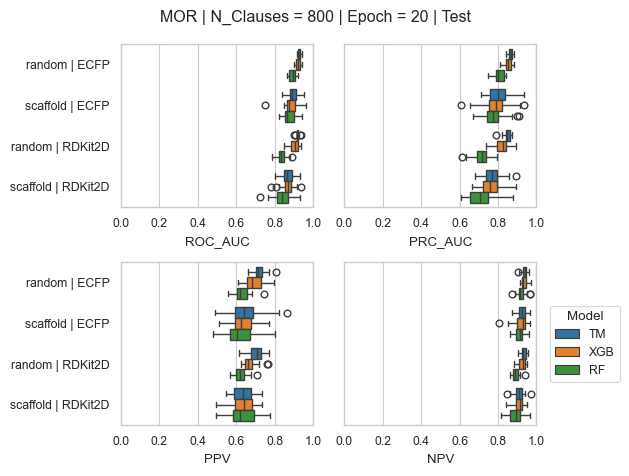

KeyboardInterrupt: 

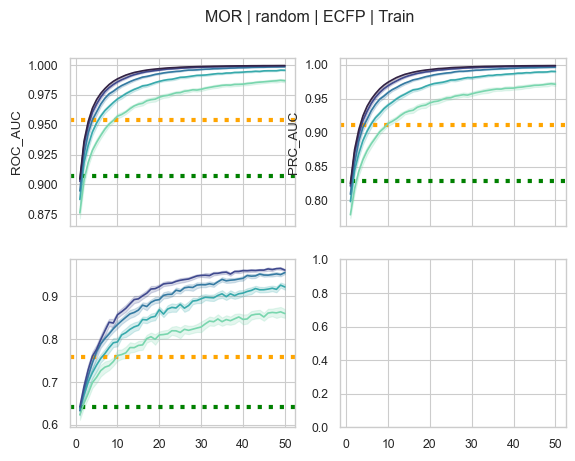

In [ ]:
sns.set_style("whitegrid")
sns.set_context("paper")

TARGET_LST = [
    "MOR",
    "DOR",
    "KOR",
    "CYP2D6",
    "CYP3A4"
]
METRIC_LST = ["ROC_AUC", "PRC_AUC", "PPV", "NPV"]
EFFECT_DICT = {'ROC_AUC':.1, 'PRC_AUC':.1, 'NPV':.1, 'PPV':.1}
DIRECTION_DICT = {'ROC_AUC':'maximize', 'PRC_AUC':'maximize', 'NPV':'maximize', 'PPV':'maximize'}

HP_LST = ["N_Clauses","N_Clauses : T","s"]

GROUP_LST = ["random", "scaffold"]
DESC_LST = ["ECFP","RDKit2D"]
DATSET_LST = ["Train", "Test"]

N_CLAUSES = 800
EPOCH = 20

for target in TARGET_LST:
    
    target_df = benchmark_results_ALL.loc[(benchmark_results_ALL["Target"] == target) & (benchmark_results_ALL["Dataset"] == "Test")]
    target_df_N = target_df.loc[(target_df["N_Clauses"] == N_CLAUSES)]
    
    tm_box_plot(
        df=target_df_N, 
        metric_lst=METRIC_LST, 
        plot_grid=(2,2), 
        npv=True, 
        epoch_col="Epochs", 
        epoch=EPOCH, 
        title_str=f"{target} | N_Clauses = {N_CLAUSES} | Epoch = {EPOCH} | Test"
    )
    
    for group in GROUP_LST:
        for desc in DESC_LST:
            for dataset in DATSET_LST:
                tm_models = benchmark_results_ALL.loc[(benchmark_results_ALL["Target"] == target) & (benchmark_results_ALL["Group"] == group) & (benchmark_results_ALL["Descriptor"]== desc) & (benchmark_results_ALL["Dataset"] == dataset) & (benchmark_results_ALL["Model"] == "TM")]
                rf_xgb_models = benchmark_results_ALL.loc[(benchmark_results_ALL["Target"] == target) & (benchmark_results_ALL["Group"] == group) & (benchmark_results_ALL["Descriptor"]== desc) & (benchmark_results_ALL["Dataset"] == dataset) & (benchmark_results_ALL["Model"] != "TM")]
                # initialize figure
                # populate figure in this loop
                
                epoch_plot(tm_df=tm_models, compar_df=rf_xgb_models, metric_lst=METRIC_LST, title_str = f"{target} | {group} | {desc} | {dataset}")
        
            target_group_desc_test_df = target_df_N.loc[(target_df_N["Group"] == group) & (target_df_N["Descriptor"] == desc)]
            
            tm_mcs_plot_grid(
                df=target_group_desc_test_df, 
                metric_lst=METRIC_LST, 
                group_col="Model",
                epoch_col="Epochs", 
                epoch=EPOCH, 
                alpha=.05, 
                plot_grid=(2,2), 
                direction_dict=DIRECTION_DICT, 
                effect_dict=EFFECT_DICT, 
                show_diff=True, 
                sort_axes=False,
                title_str=f"{target} | {group} | {desc} | N_Clauses = {N_CLAUSES} | Epoch = {EPOCH} | Test"
            )
            
            
            tm_target_group_desc_test_df = target_df.loc[(target_df["Group"] == group) & (target_df["Descriptor"] == desc) & (target_df["Model"] == "TM")]
            
            tm_hyperparameter_plot(
                df=tm_target_group_desc_test_df, 
                metric_lst=METRIC_LST, 
                hp_lst=HP_LST, 
                log2=False, 
                param_col="Params", 
                epoch_col="Epochs", 
                epoch=EPOCH, 
                plot_grid=(2,2), 
                title_str=f"{target} | {group} | {desc} | Epoch = {EPOCH} | Test"
            )
            
            
            


In [ ]:
wireframe_df = tm_Epochs_20_HP.groupby("N_Clauses")[["T : N_Clauses", "s", "Score"]].mean()

In [ ]:

wireframe_df["T : N_Clauses"].values
wireframe_df.index.values

array([ 100,  200,  400,  800, 1600])

In [ ]:
tm_models = benchmark_results_ALL.loc[(benchmark_results_ALL["Dataset"] == "Test") & (benchmark_results_ALL["ScoreType"] == "ROC_AUC") & (benchmark_results_ALL["Target"] == "CYP3A4") & (benchmark_results_ALL["GroupDescriptorModel"]== "random | ECFP | TM")]
rf_xgb_models = benchmark_results_ALL.loc[(benchmark_results_ALL["Dataset"] == "Test") & (benchmark_results_ALL["ScoreType"] == "ROC_AUC") & (benchmark_results_ALL["Target"] == "CYP3A4") & (benchmark_results_ALL["Model"] != "TM") & (benchmark_results_ALL["GroupDescriptor"]== "random | ECFP")]
rf_xgb_models.groupby(['Model'])['Score'].mean()

Model
RF     0.782447
XGB    0.864968
Name: Score, dtype: float64

/var/folders/0g/d7tvnyvn0gn00hj9fq4rykxw0000gp/T/ipykernel_76016/2185802064.py:5: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  epoch_plt = sns.lineplot(


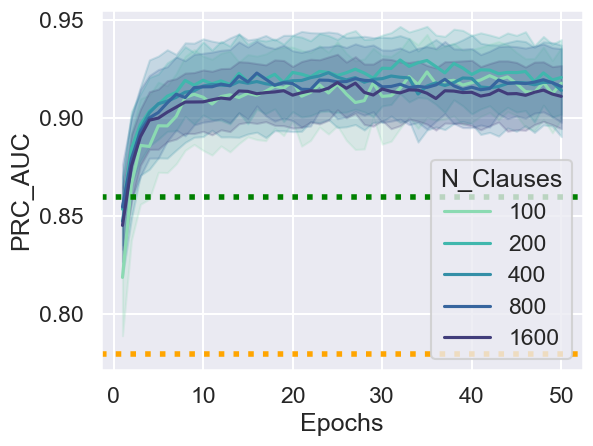

In [ ]:
sns.set_theme()
sns.set_context("talk")

palette = sns.color_palette("mako_r", 6)
epoch_plt = sns.lineplot(
    data=tm_models,
    x="Epochs",
    y="Score",
    hue="N_Clauses",
    palette=palette
)
epoch_plt.axhline(y=0.78, linewidth=4, color='orange', ls=':')
epoch_plt.axhline(y=0.86, linewidth=4, color='green', ls=':')
epoch_plt.set_ylabel("PRC_AUC")
plt.tight_layout()
plt.show()


In [ ]:
final_test_scaffold_ECFP = benchmark_results.loc[(benchmark_results["Dataset"] == "Test") & (benchmark_results["Epochs"] == 10) & (benchmark_results["Descriptor"] == "ECFP") & (benchmark_results["Group"] == "scaffold")]
final_test_random_ECFP = benchmark_results.loc[(benchmark_results["Dataset"] == "Test") & (benchmark_results["Epochs"] == 10) & (benchmark_results["Descriptor"] == "ECFP") & (benchmark_results["Group"] == "random")]

In [ ]:
final_test_random_ECFP

,TargetDataset,Group,Split,Fold,Descriptor,HPSearchTime,TrainTime,InferenceTime,TotalTime,Params,Epochs,Model,Dataset,Score,ScoreType
76,opioids/MOR_cutoff6.csv,random,0,0,ECFP,78.010776,30.542313,0.541203,109.094292,"{'T': 3985, 's': 2.605117594571127, 'number_of...",10,TsetlinMachine,Test,0.922460,ROC_AUC
77,opioids/MOR_cutoff6.csv,random,0,0,ECFP,78.010776,30.542313,0.541203,109.094292,"{'T': 3985, 's': 2.605117594571127, 'number_of...",10,TsetlinMachine,Test,0.846000,PRC_AUC
78,opioids/MOR_cutoff6.csv,random,0,0,ECFP,78.010776,30.542313,0.541203,109.094292,"{'T': 3985, 's': 2.605117594571127, 'number_of...",10,TsetlinMachine,Test,0.657040,PPV
79,opioids/MOR_cutoff6.csv,random,0,0,ECFP,78.010776,30.542313,0.541203,109.094292,"{'T': 3985, 's': 2.605117594571127, 'number_of...",10,TsetlinMachine,Test,0.948837,NPV
84,opioids/MOR_cutoff6.csv,random,0,0,ECFP,4.735992,0.534450,0.010844,5.281286,"{'max_depth': 89, 'ccp_alpha': 0.0030340592973...",10,RandomForest,Test,0.879785,ROC_AUC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1431,opioids/MOR_cutoff6.csv,random,1,2,ECFP,4.637607,0.614454,0.024382,5.276443,"{'max_depth': 72, 'ccp_alpha': 0.0012058106552...",10,RandomForest,Test,0.938914,NPV
1436,opioids/MOR_cutoff6.csv,random,1,2,ECFP,3.212107,0.418581,0.005531,3.636219,"{'max_depth': 10, 'learning_rate': 0.080097783...",10,XGBoost,Test,0.919109,ROC_AUC
1437,opioids/MOR_cutoff6.csv,random,1,2,ECFP,3.212107,0.418581,0.005531,3.636219,"{'max_depth': 10, 'learning_rate': 0.080097783...",10,XGBoost,Test,0.855274,PRC_AUC
1438,opioids/MOR_cutoff6.csv,random,1,2,ECFP,3.212107,0.418581,0.005531,3.636219,"{'max_depth': 10, 'learning_rate': 0.080097783...",10,XGBoost,Test,0.711462,PPV


In [ ]:
sns.catplot(
    final_test_random_ECFP, x="ScoreType", y="Score", hue="Model",
    kind="violin",
    color=".9",
    inner=None,
    legend=False
)
sns.swarmplot(
    final_test_random_ECFP, x="ScoreType", y="Score", hue="Model",
    dodge=True,
    alpha=0.5,
    legend=True
)

- Inference speed (classification speed)
- Statistical Tests
--> Wilcoxin signed-rank test - revision and implementation

- Time and energy usage (single core RF, XGBoost) 
--> Using ParallelTM
--> Bug fixing
--> os.environ['OMP_NUM_THREADS'] = "5"
--> All methods will reference this

- Scalability
--> Papyrus dataset received from Ivan

- Next week's task
--> Re-run with ParallelTM with each method using same number of cores
--> With increase number of rules to 1000

- pyJoules

In [ ]:
final_test_random_ECFP_pivot = pd.pivot_table(data=final_test_random_ECFP, index=["Split", "Fold", "Model"], values="Score", columns=["ScoreType"]).reset_index()
final_test_random_ECFP_pivot

ScoreType,Split,Fold,Model,NPV,PPV,PRC_AUC,ROC_AUC
0,0,0,RandomForest,0.926366,0.604895,0.762836,0.879785
1,0,0,TsetlinMachine,0.948837,0.657040,0.846000,0.922460
2,0,0,XGBoost,0.921277,0.704641,0.845105,0.922982
3,0,1,RandomForest,0.869379,0.620833,0.718053,0.839513
4,0,1,TsetlinMachine,0.918200,0.779817,0.864177,0.930785
5,0,1,XGBoost,0.943662,0.661922,0.843818,0.921917
6,0,2,RandomForest,0.899573,0.673640,0.808252,0.880525
7,0,2,TsetlinMachine,0.928279,0.789954,0.881486,0.937447
8,0,2,XGBoost,0.941964,0.702703,0.884690,0.936561
9,0,3,RandomForest,0.935065,0.635514,0.830372,0.902690


In [ ]:
metric_lst = ["ROC_AUC", "PRC_AUC", "PPV", "NPV"]
effect_dict = {'ROC_AUC':.1, 'PRC_AUC':.1, 'NPV':.1, 'PPV':.1}
direction_dict = {'ROC_AUC':'maximize', 'PRC_AUC':'maximize', 'NPV':'maximize', 'PPV':'maximize'}

make_mcs_plot_grid(final_test_random_ECFP_pivot,
                   stats=metric_lst,
                   group_col="Model",
                   effect_dict=effect_dict,
                   direction_dict=direction_dict, sort_axes=True)

In [ ]:
make_normality_diagnostic(final_test_random_ECFP_pivot, metric_ls=metric_lst)

In [ ]:
make_ci_plot_grid(df_in=final_test_random_ECFP_pivot, metric_list=metric_lst, group_col="Model")

In [ ]:
micro_cols = ["TargetDataset", "Group", "Split", "Fold", "Descriptor", "Epochs", "Model", "Dataset", "Y_Index", "Y_True", "Y_Pred"]

micro_results = pd.read_csv("MICRO_Test_POLARIS", names=micro_cols)
micro_results_ECFP_random_test = micro_results.loc[(micro_results["Dataset"] == "Test") & (micro_results["Epochs"] == 10) & (micro_results["Descriptor"] == "ECFP") & (micro_results["Group"] == "random")]
micro_results_ECFP_random_test_TM = micro_results_ECFP_random_test.loc[(micro_results_ECFP_random_test["Model"] == "TsetlinMachine")]
micro_results_ECFP_random_test_XGB = micro_results_ECFP_random_test.loc[(micro_results_ECFP_random_test["Model"] == "XGBoost")]

micro_results_ECFP_random_test_TM
micro_results_ECFP_random_test_TM.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17665 entries, 34623 to 2070337
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TargetDataset  17665 non-null  object 
 1   Group          17665 non-null  object 
 2   Split          17665 non-null  int64  
 3   Fold           17665 non-null  int64  
 4   Descriptor     17665 non-null  object 
 5   Epochs         17665 non-null  int64  
 6   Model          17665 non-null  object 
 7   Dataset        17665 non-null  object 
 8   Y_Index        17665 non-null  int64  
 9   Y_True         17665 non-null  int64  
 10  Y_Pred         17665 non-null  float64
dtypes: float64(1), int64(5), object(5)
memory usage: 1.6+ MB


In [ ]:
tm_Y_pred = micro_results_ECFP_random_test_TM[['Y_Index', 'Y_True', 'Y_Pred']].groupby('Y_Index').mean().loc[:,'Y_Pred']
Y_true = micro_results_ECFP_random_test_TM[['Y_Index', 'Y_True', 'Y_Pred']].groupby('Y_Index').mean().loc[:, 'Y_True']
xgb_Y_pred = micro_results_ECFP_random_test_XGB[['Y_Index', 'Y_True', 'Y_Pred']].groupby('Y_Index').mean().loc[:,'Y_Pred']
xgb_Y_pred

Y_Index
0       0.689469
1       0.782571
2       0.797355
3       0.614649
4       0.669259
          ...   
3528    0.343291
3529    0.806144
3530    0.716463
3531    0.587524
3532    0.368875
Name: Y_Pred, Length: 3533, dtype: float64

In [ ]:
ax = sns.scatterplot(
    x=xgb_Y_pred,
    y=tm_Y_pred,
    hue=Y_true
)
ax.set(xlabel='XGBoost Y_pred_proba', ylabel='TsetlinMachine Y_pred_proba')
plt.show()

In [ ]:
micro_results_ECFP_random_test_TM = micro_results_ECFP_random_test.loc[(micro_results_ECFP_random_test["Model"] == "TsetlinMachine")]

In [ ]:
tm_MOR = benchmark_results.loc[(benchmark_results["Model"] == "TsetlinMachine") & (benchmark_results["TargetDataset"] == "opioids/KOR_cutoff6.csv")]
tm_MOR

,TargetDataset,Group,Split,Fold,Descriptor,HPSearchTime,TrainTime,InferenceTime,TotalTime,Params,Epochs,Model,Dataset,Score,ScoreType


In [ ]:
g = sns.relplot(
    data=tm_MOR,
    x= "Epochs",
    y= "Score",
    col= "SplitType",
    row= "Descriptor",
    hue = "Dataset",
    style= "ScoreType",
    kind="line"
)
g

In [ ]:
g = sns.FacetGrid(tm_MOR, col = "SplitType", row="Descriptor", hue="ScoreType")
g.map(sns.lineplot, "Epochs", "Score", style="Dataset") 

In [5]:
def csv_to_latex_table(csv_path, index=False, float_format="%.3f"):
    """
    Reads a CSV file and returns its LaTeX table representation as a string.

    Args:
        csv_path (str): Path to the CSV file.
        index (bool): Whether to include the DataFrame index in the output.
        float_format (str): Format string for floating point numbers.

    Returns:
        str: LaTeX table as a string.
    """
    df = pd.read_csv(csv_path)
    latex_str = df.to_latex(index=index, float_format=float_format)
    return latex_str

# Example usage:
# latex_table = csv_to_latex_table("SummaryTableCSV.csv")
# print(latex_table)

In [6]:
latex_str = csv_to_latex_table("SummaryTableCSV.csv", index=False, float_format="%.3f")

In [7]:
latex_str

'\\begin{tabular}{llllllllllllll}\n\\toprule\nUnnamed: 0 & Unnamed: 1 & Unnamed: 2 & ROC_AUC & Unnamed: 4 & PRC_AUC & Unnamed: 6 & PPV & Unnamed: 8 & NPV & Unnamed: 10 & Unnamed: 11 & Unnamed: 12 & Unnamed: 13 \\\\\n\\midrule\nNaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN \\\\\nTarget & Descriptor & Group & TM Score & CI - NearestTree & TM Score & CI - NearestTree & TM Score & CI - NearestTree & TM Score & CI - NearestTree & Target Colour Count & NaN & NaN \\\\\nNaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN \\\\\nMOR  & ECFP & Random & 0.93 & 99% & 0.87 & 99% & 0.72 & 99% & 0.94 & NaN & MOR & NaN & NaN \\\\\nNaN & NaN & Scaffold & 0.89 & 90% & 0.8 & 90% & 0.65 & NaN & 0.92 & 99% & "Better" & "The Same" & "Worse" \\\\\nNaN & RDKit2D & Random & 0.92 & 99% & 0.85 & 99% & 0.7 & 99% & 0.93 & 90% & 11 & 5 & 0 \\\\\nNaN & NaN & Scaffold & 0.87 & NaN & 0.77 & 90% & 0.64 & NaN & 0.91 & NaN & NaN & NaN & NaN \\\\\nDOR  & ECF